# Modeling a Moving Average Process

#### Loading Libraries

In [43]:
# Math Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Modelling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# warnings
import warnings

# Scikit-Learn Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

#### Loading Data

In [5]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


##### Plotting out Widget_sales

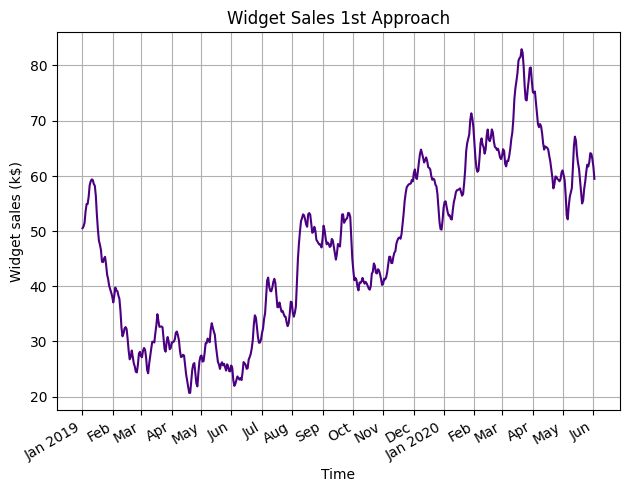

In [6]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], color='indigo')
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Widget Sales 1st Approach')
plt.grid(True)

##### Checking for Stationarity

In [7]:
ADF_result = adfuller(df['widget_sales'])

print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -1.5121662069359003
p-value: 0.5274845352272627


##### Applying Transformation

In [8]:
# 1st Order Differencing
widget_sales_diff = np.diff(df['widget_sales'], n=1)

##### Plotting on Differenced Serie: Looking for Trend Stabilization

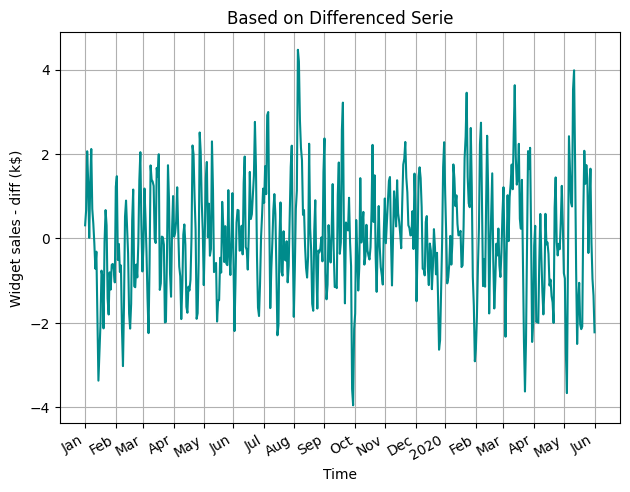

In [9]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff, color='darkcyan')
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Based on Differenced Serie')
plt.grid(True)

In [10]:
# Running on a ADF test based on differenced data
ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -10.576657780341957
p-value: 7.076922818587346e-19


##### Checking for Autocorrelations

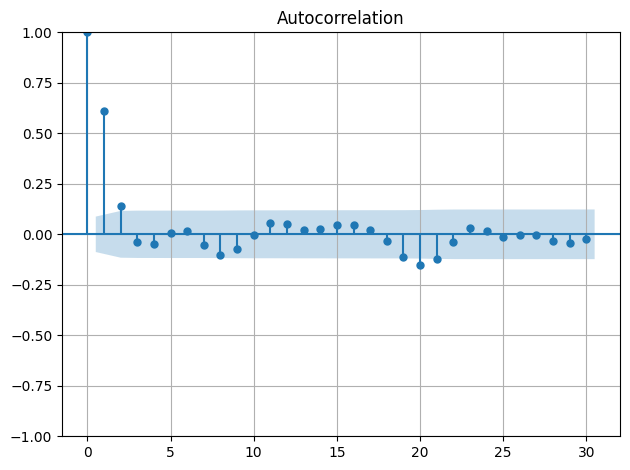

In [14]:
plot_acf(widget_sales_diff, lags=30);

plt.tight_layout()
plt.grid(True)

### Forecasting a Moving Average Process

In [15]:
# Setting Widget Sales Differenced on DataFrame
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

# Train on 90%
train = df_diff[:int(0.9*len(df_diff))]
# Testing on 10%
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


##### Plotting on

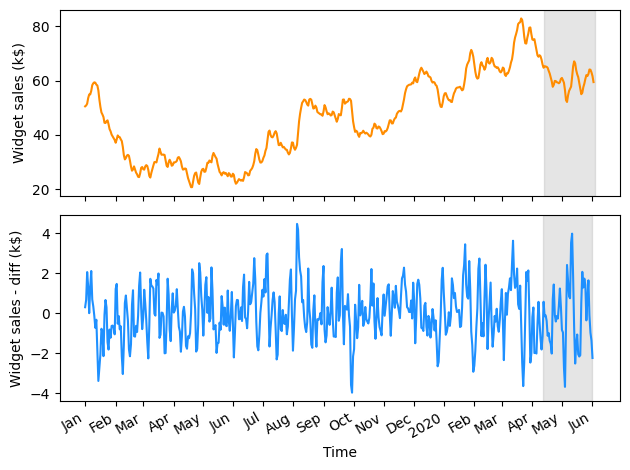

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'], color='darkorange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'], color='dodgerblue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
# plt.title('Forecasting Period: Original vs. Differenced Series')
# plt.show()

#### Working on SARIMAX

##### Rolling Forecast Function

In [27]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [28]:
# Setting Copy
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


##### Plotting on 

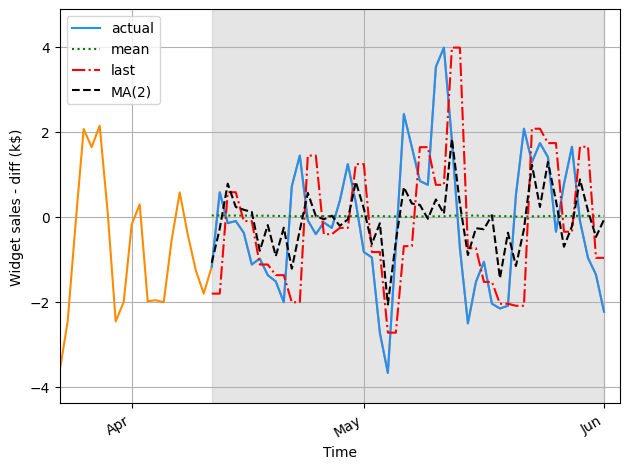

In [36]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'], color='darkorange')
ax.plot(pred_df['widget_sales_diff'], '-', label='actual', color='dodgerblue')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], '-.', label='last', color='red')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.grid(True)

##### Checking Model Performance

In [38]:
# from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497384723


##### Model Performance Visualization

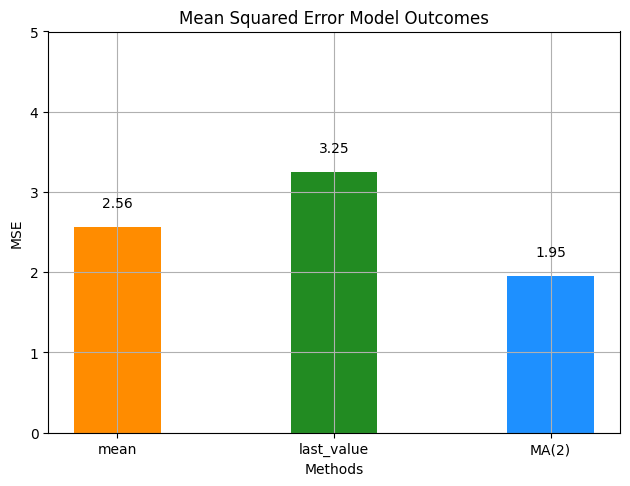

In [39]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4, color=['darkorange', 'forestgreen', 'dodgerblue'])
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.title('Mean Squared Error Model Outcomes')
plt.grid(True)

##### Reverting & applying cumulative sum

In [40]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

##### Checking Untransformed Predictions

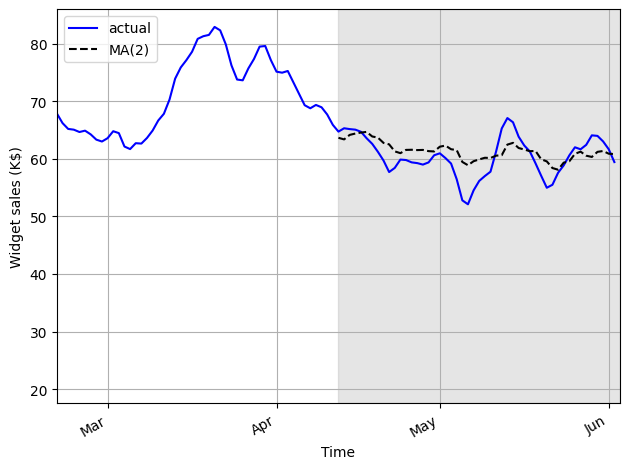

In [42]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.grid(True)

### Reporting (MAE) on original set

In [44]:
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

2.324470924401271
